In [1]:
import numpy as np
import tensorflow as tf
import utils
from joblib import load
import matplotlib.pyplot as plt

<a href="https://colab.research.google.com/github/NahuelCostaCortez/DTW-Li-ion-Diagnosis/blob/main/experimentalResults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
chemistry = 'LFP' # 'LFP' or 'NMC' or 'NCA'

path = './mat/'+chemistry
size = utils.SIZE
min_val = utils.LFP_MIN # utils.NMC_MIN or utils.NCA_MIN
max_val = utils.LFP_MAX # utils.NMC_MAX or utils.NCA_MAX
Q = utils.read_mat('./mat/Q.mat')['Qnorm'].flatten()
y_test = utils.read_mat(path+'/y_test.mat')['y_test']

x_test_1 = utils.read_mat(path+'/x_test_1.mat')['x_test'].T
x_test_2 = utils.read_mat(path+'/x_test_2.mat')['x_test'].T
x_test_3 = utils.read_mat(path+'/x_test_3.mat')['x_test'].T

Plot some data

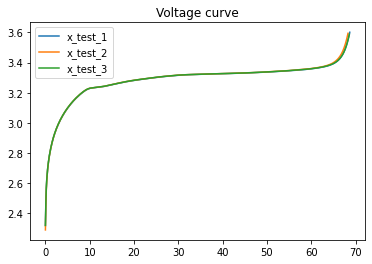

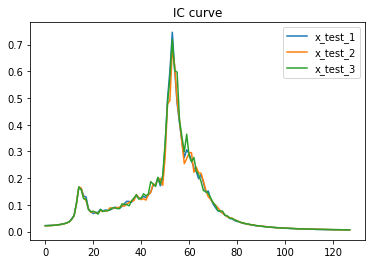

In [3]:
duty = np.random.randint(0, y_test.shape[0])
cycle = np.random.randint(0, y_test.shape[1])

datasets = [x_test_1, x_test_2, x_test_3]
labels = ['x_test_1', 'x_test_2', 'x_test_3']

plt.title("Voltage curve")
for i, data in enumerate(datasets):
    plt.plot(Q, data[duty, cycle], label=labels[i])
plt.legend()
plt.show()

# convert data to IC
plt.title("IC curve")
for i, data in enumerate(datasets):
    ui, dqi = utils.IC(data[duty,cycle], Q)
    plt.plot(utils.reduce_size(ui, dqi, size), label=labels[i])
plt.legend()
plt.show()

Convert to input data

In [4]:
y_test = y_test/100
y_test = y_test.reshape(-1, y_test.shape[2])

processed_test_datasets = []

# x_test_0 is part of the training set, so we don't need it
for dataset in datasets:
    dataset = dataset.reshape(-1, dataset.shape[2])
    dataset = utils.convert_to_input_data(dataset, Q, size-1, chemistry)
    dataset = utils.normalise_data(dataset, min_val, max_val)
    processed_test_datasets.append(dataset)

Load models

In [5]:
# Models
model_RF = load('./saved/'+chemistry+'/model-RF.joblib')
model_FFN = tf.keras.models.load_model('./saved/'+chemistry+'/model-MLP.h5')
model_CNN = tf.keras.models.load_model('./saved/'+chemistry+'/model-CNN.h5')
model_DTW = tf.keras.models.load_model('./saved/'+chemistry+'/model-DTWCNN.h5')

/home/nahuel/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/nahuel/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# FFN

In [6]:
utils.get_pred(model_FFN, processed_test_datasets, y_test, False, False)

,10,50,100,200,400,1000
LLI,1.897386,1.937745,2.004651,1.820726,1.672401,3.916146
LAMPE,2.533825,2.903456,3.098658,3.285525,3.583620,11.118142
LAMNE,2.303765,2.328015,2.321713,2.103639,2.159653,6.319307


,10,50,100,200,400,1000
LLI,2.065159,2.166340,2.234195,1.811590,1.558170,3.679649
LAMPE,3.302188,2.941344,2.948705,2.735347,3.465126,11.320685
LAMNE,3.413675,3.294412,3.289092,2.778900,2.350681,6.191301


,10,50,100,200,400,1000
LLI,1.451380,1.931783,1.889349,1.684941,1.733579,4.029704
LAMPE,2.272202,3.145731,3.404697,3.524634,3.784329,11.310488
LAMNE,3.047854,3.068850,2.984351,2.648276,2.443732,6.378584


# RF

In [7]:
utils.get_pred(model_RF, processed_test_datasets, y_test, False, False)

,10,50,100,200,400,1000
LLI,6.326812,5.696067,4.940409,3.629421,3.233855,9.211487
LAMPE,5.896490,5.132423,4.262228,3.153127,5.164388,9.136563
LAMNE,7.002441,6.064502,5.020779,3.820403,6.249853,11.837801


,10,50,100,200,400,1000
LLI,6.326812,5.696067,4.940409,3.642654,3.148818,9.222205
LAMPE,5.896490,5.132423,4.262228,3.172645,4.971949,9.793606
LAMNE,7.002441,6.064502,5.020779,3.826087,6.381696,11.558122


,10,50,100,200,400,1000
LLI,6.326812,5.696067,4.940409,3.629421,3.201966,9.135190
LAMPE,5.896490,5.132423,4.262228,3.153127,5.071271,9.375053
LAMNE,7.002441,6.064502,5.020779,3.820403,6.185985,11.665670


# 1DConv

In [8]:
utils.get_pred(model_CNN, processed_test_datasets, y_test, True, False)

,10,50,100,200,400,1000
LLI,1.180207,0.951202,0.733230,1.065122,1.689569,3.216216
LAMPE,1.901536,1.238535,1.805410,2.801486,3.385904,10.737505
LAMNE,1.182502,1.336198,1.271986,1.719755,2.833926,6.605924


,10,50,100,200,400,1000
LLI,0.630395,0.596814,0.860183,1.113128,1.621577,3.155063
LAMPE,0.418775,1.289180,2.760915,2.629113,3.504882,10.856303
LAMNE,2.050356,1.832850,2.030776,2.364677,2.864634,6.581638


,10,50,100,200,400,1000
LLI,1.950257,0.899970,0.604320,0.969911,1.752043,3.351155
LAMPE,2.085784,1.158399,2.012010,2.957311,3.447960,10.860979
LAMNE,2.867554,1.979410,1.591945,2.074955,2.930547,6.616024


# DTW-CNN

In [9]:
V_references = utils.read_mat(path+'/V_references.mat')['V_references']

processed_test_datasets_DTW = []

# this usually takes some minutes, be patient!
for V, x_test in zip(V_references, processed_test_datasets):
    # get IC reference
    ui, dqi = utils.IC(V, Q, utils.UI_STEP, utils.MIN_V_LFP, utils.MAX_V_LFP) # change to NCA/NMC if needed
    new_sample = utils.reduce_size(ui, dqi, size-1)
    IC_reference = utils.normalise_data(new_sample, min_val, max_val)
    # get DTW images
    processed_test_datasets_DTW.append(utils.get_DTWImages(x_test, IC_reference, size))

In [10]:
utils.get_pred(model_DTW, processed_test_datasets_DTW, y_test, False, True)

,10,50,100,200,400,1000
LLI,0.147196,0.533658,0.728286,1.161802,1.312178,2.474986
LAMPE,0.968427,0.983055,1.826342,2.673091,3.591306,8.643713
LAMNE,0.177229,0.706995,1.408829,1.984942,1.932055,3.867265


,10,50,100,200,400,1000
LLI,0.449007,0.842166,0.916717,1.186617,1.325558,2.155543
LAMPE,0.785202,2.067852,2.765922,3.220181,3.926521,8.893262
LAMNE,0.216502,0.574732,0.800012,1.117781,1.418098,4.011069


,10,50,100,200,400,1000
LLI,0.800950,0.568149,0.565061,0.953905,1.120239,2.588985
LAMPE,2.309712,1.322498,2.038502,2.723597,3.678208,8.632853
LAMNE,0.599813,0.553767,1.003389,1.433580,1.640689,3.940036
